In [56]:
import numpy as np
import pandas as pd

df = pd.read_csv("flaredown_trackable_data_080316.csv")
df['checkin_date'] = pd.to_datetime(df['checkin_date'])

Before we make the word clouds we need to filter out duplicates per user so that each user only has one line for each symptom and tag.  This way we are creating the word cloud based on how many users are experiencing the symptoms.  Otherwise the users who log the most dominate the word counts, and we end up with a list of symptoms logged by only those few users, and this results in very similar word clouds for each condition.

There are also a few symptoms that are very common and tend to dominate all of the clouds.  Removing them as I feel that the word clouds are more informative without them.

In [77]:
df = df.drop_duplicates(['user_id', 'trackable_name'])

df = df[df['trackable_name'] != "Fatigue"]
df = df[df['trackable_name'] != "tired"]
df = df[df['trackable_name'] != "Headache"]

And then find what the top conditions are, so we can create the wordclouds on the most common conditions.

In [78]:
df_conditions = df[df['trackable_type'] == 'Condition']
topConditions = df_conditions['trackable_name'].value_counts().index[0:15]

This next step uses a library called wordcloud https://github.com/amueller/word_cloud
You may need to:
pip install wordcloud 


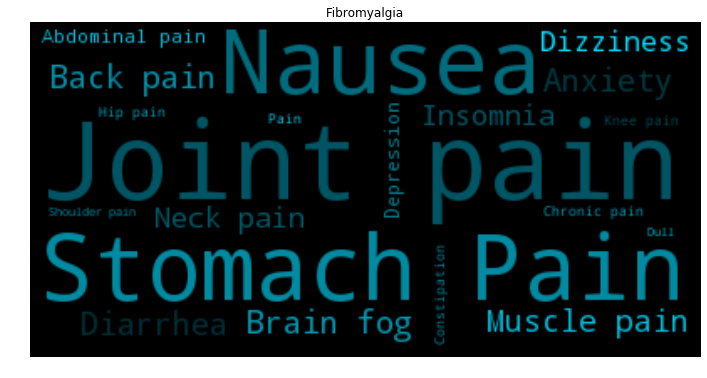

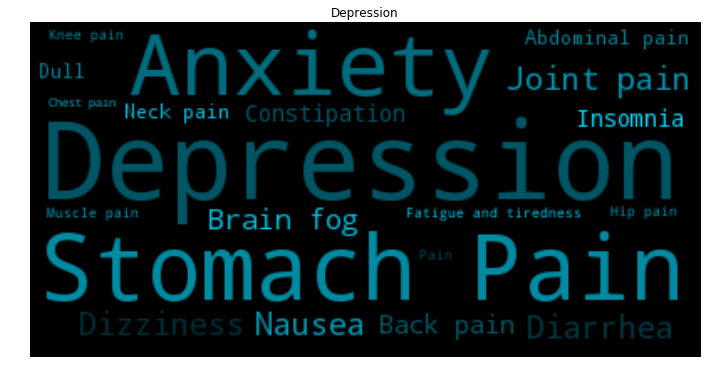

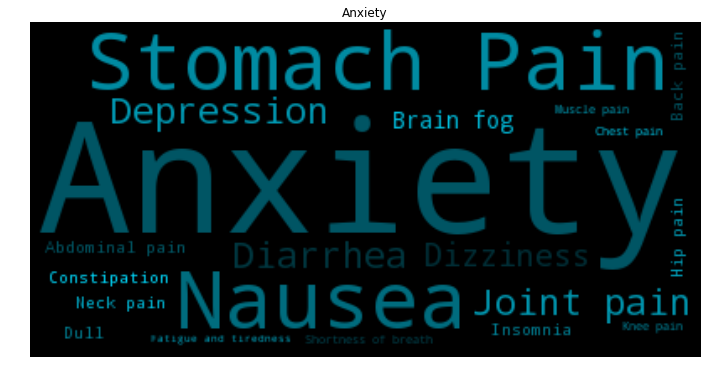

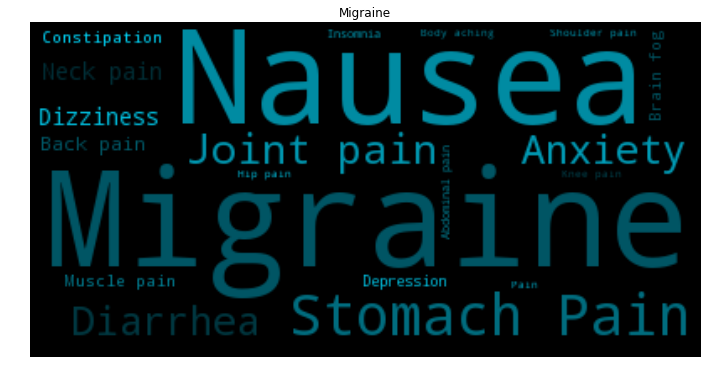

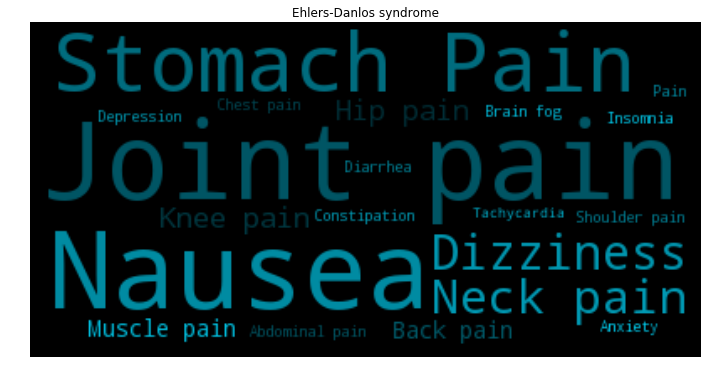

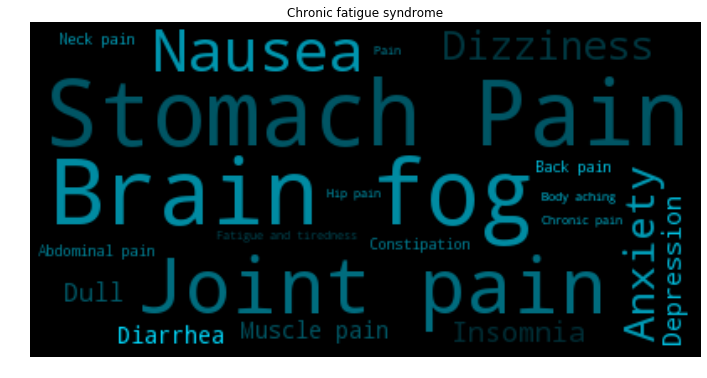

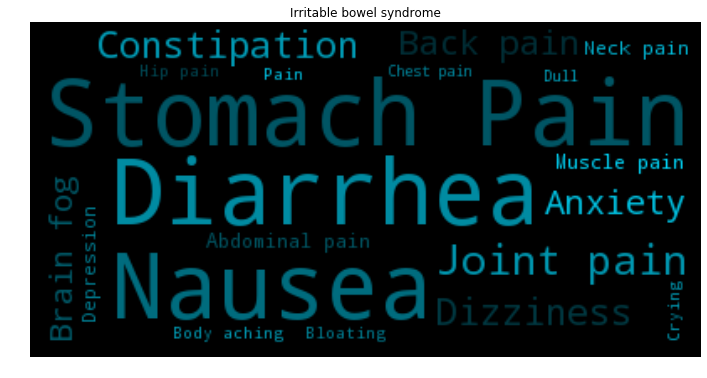

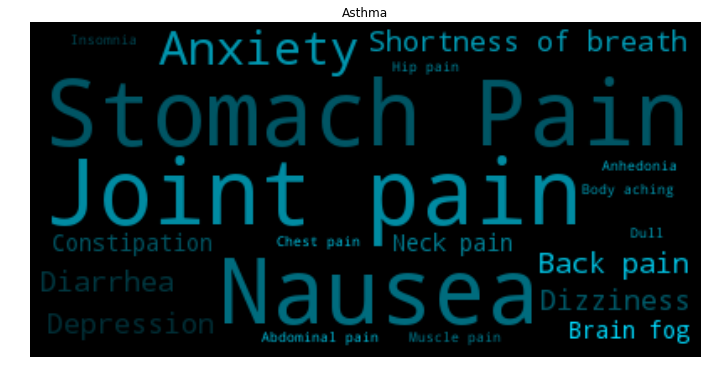

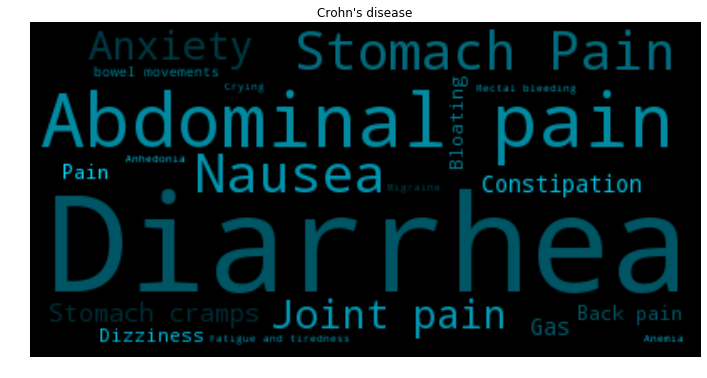

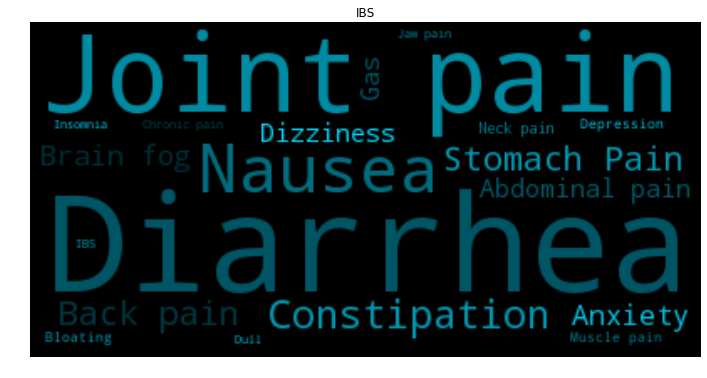

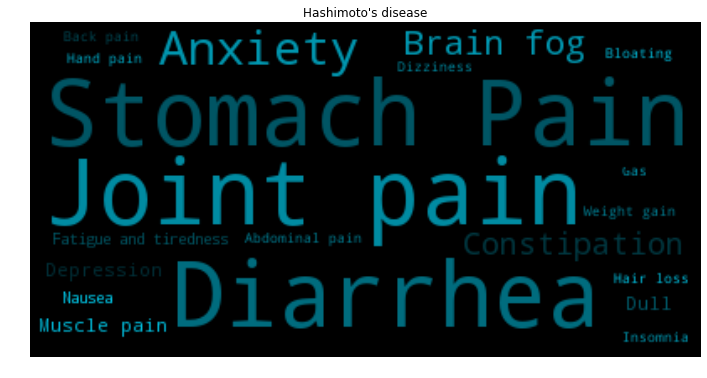

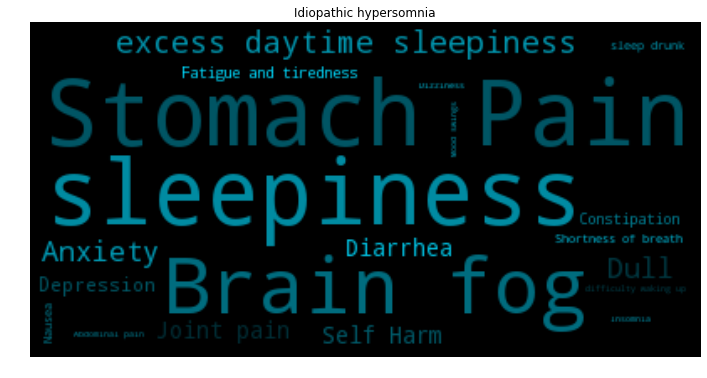

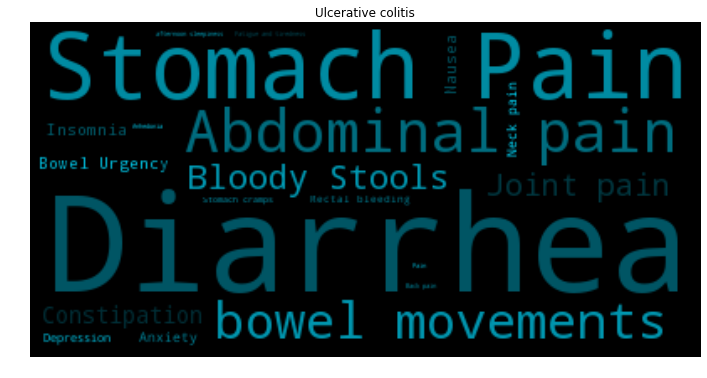

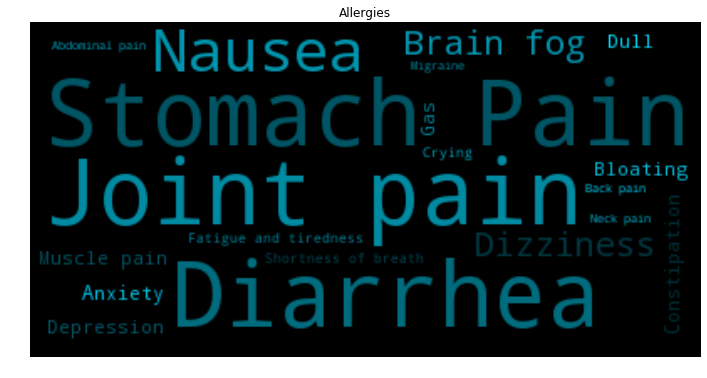

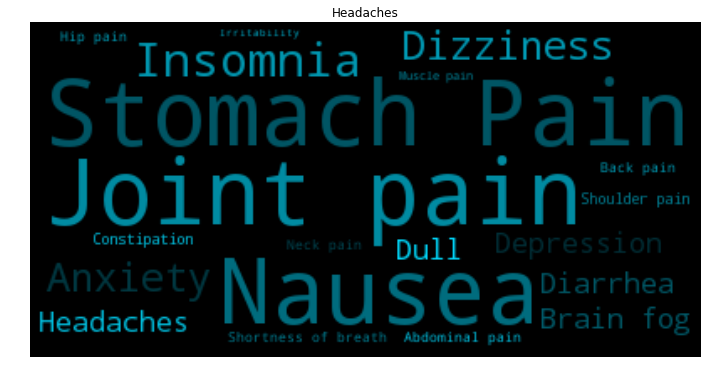

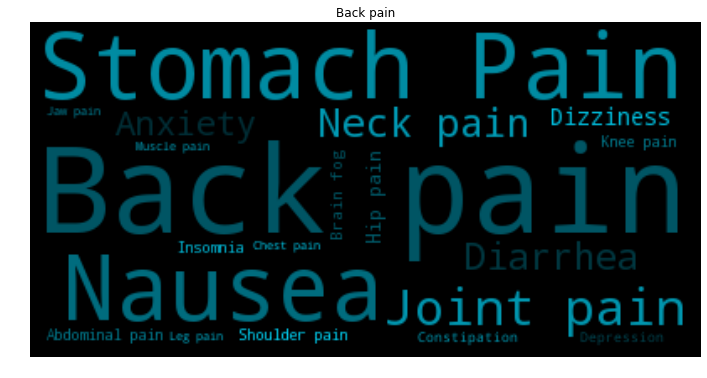

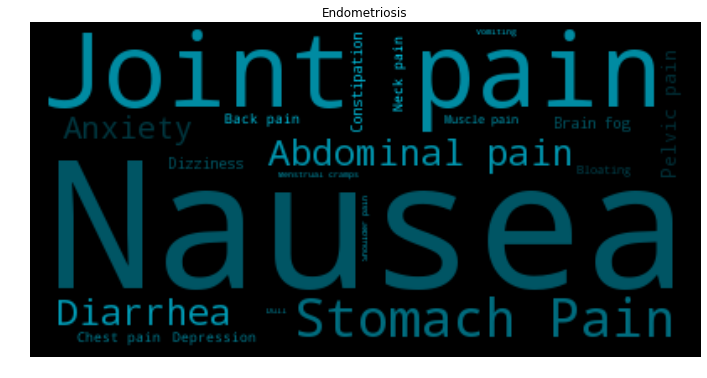

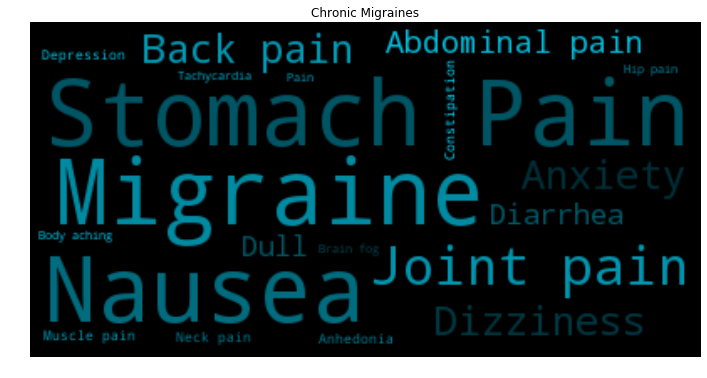

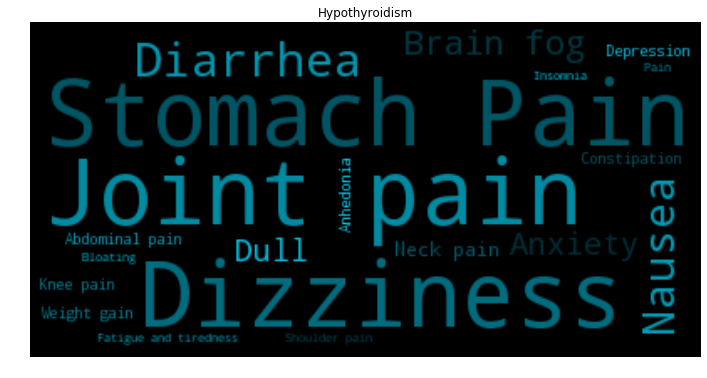

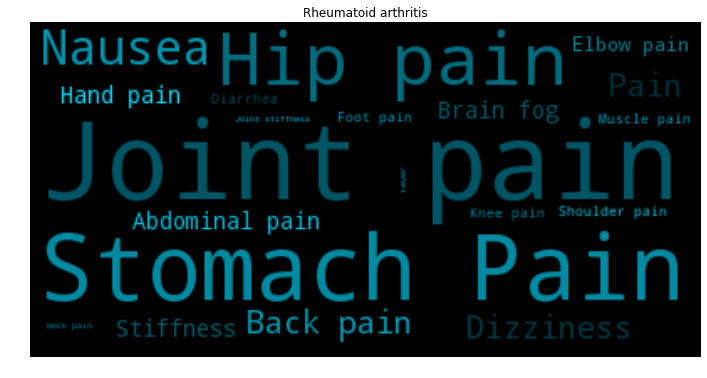

In [81]:
from wordcloud import WordCloud, get_single_color_func
%matplotlib inline
from collections import defaultdict
import matplotlib.pyplot as plt
import random

def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

for condition in topConditions:
    just_affected_users = df.groupby('user_id').filter(lambda x: condition in x['trackable_name'].values)
    symptoms = just_affected_users[just_affected_users['trackable_type'] == 'Symptom']
    symptom_counts = defaultdict(int)
    #need to get the counts into this defaultdict nonsense
    for key,value in symptoms['trackable_name'].value_counts().to_dict().iteritems():
        symptom_counts[key] = value
    wc = WordCloud(max_words=20, margin=10,random_state=1)
    wc.generate_from_frequencies(symptom_counts.items())
    default_colors = wc.to_array()
    plt.figure(figsize=(12, 8))
    plt.title(condition)
    plt.axis("off")
    color_func2 = get_single_color_func('#00b4d2')  #specify an rgb color here
    #plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3)) uncomment here if you like greyscale
    plt.imshow(wc.recolor(color_func=color_func2, random_state=3))

Now lets add in our tags.  It is expected that since the symptoms are usually the same across users, and the tags aren't they won't be as represented in the cloud.  We will also create a color function that colours the tag words differently than the symptoms.

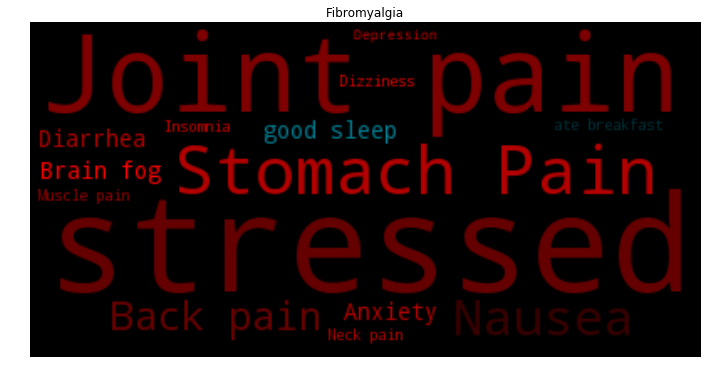

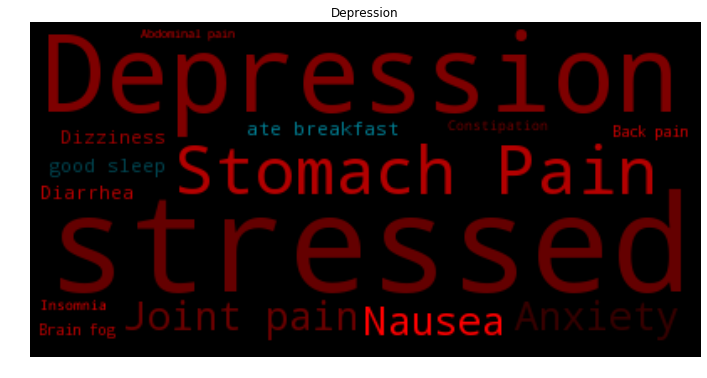

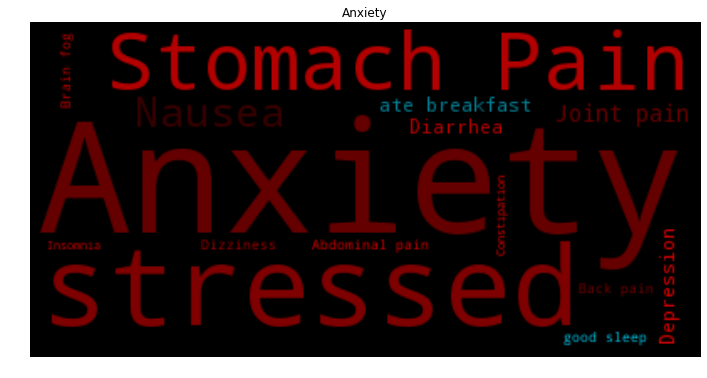

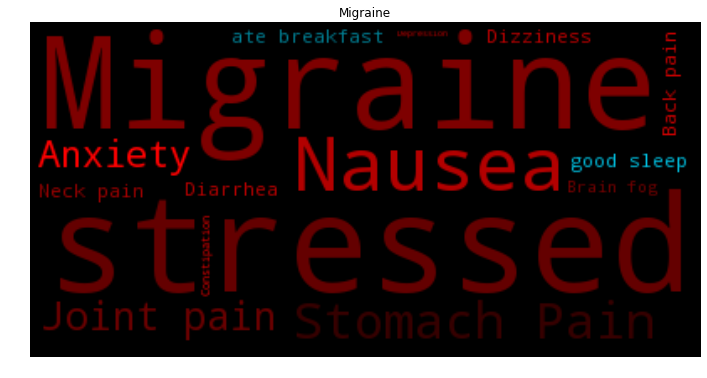

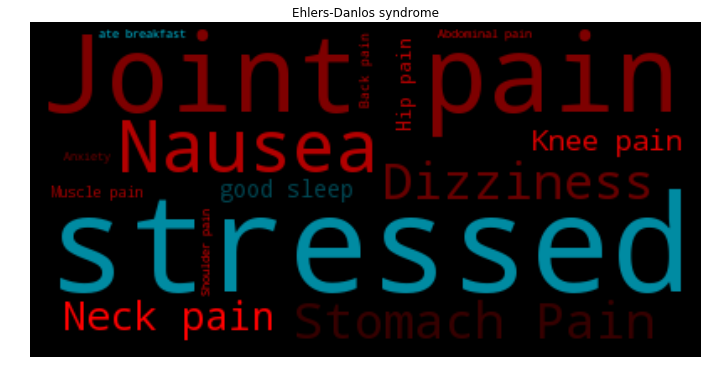

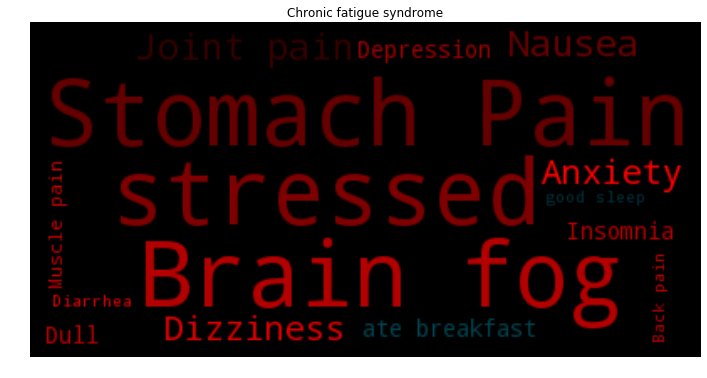

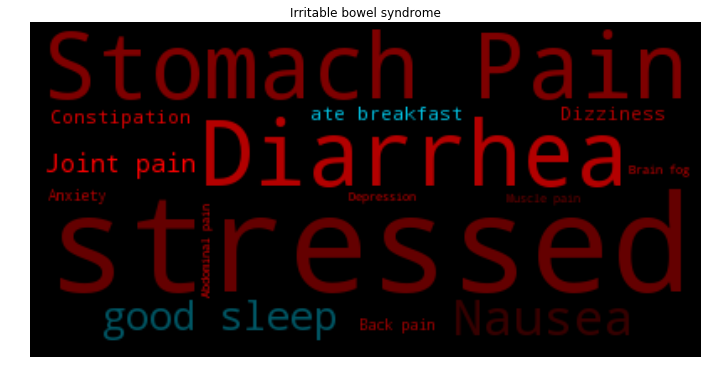

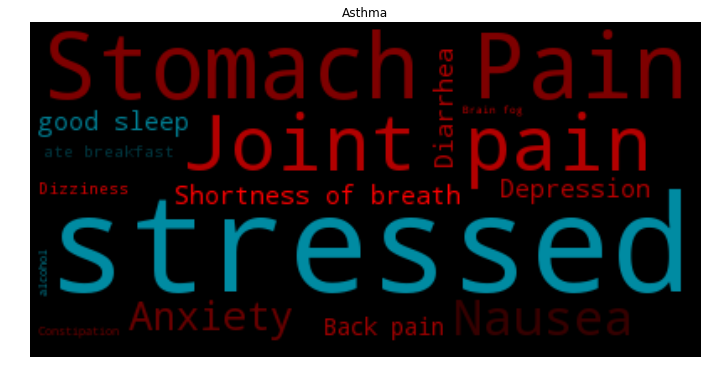

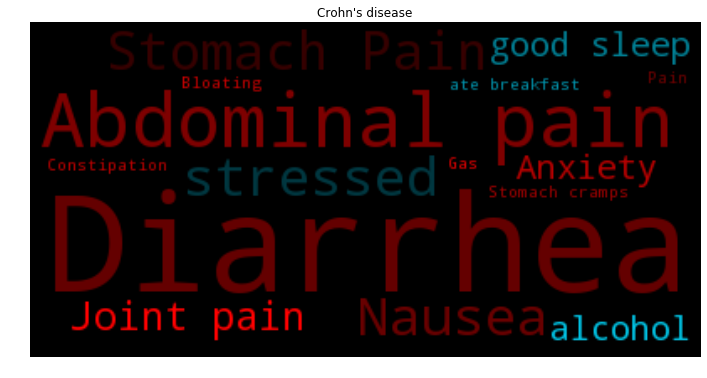

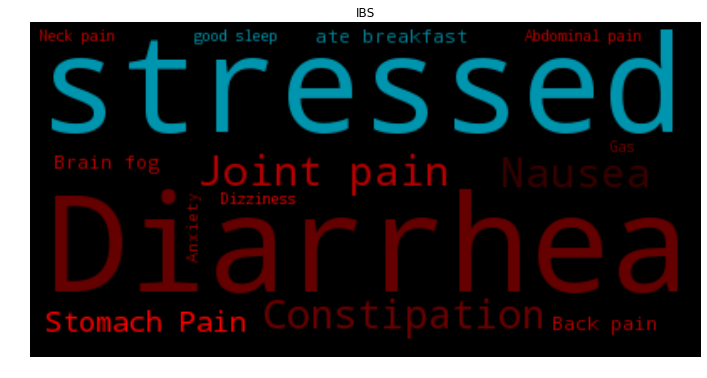

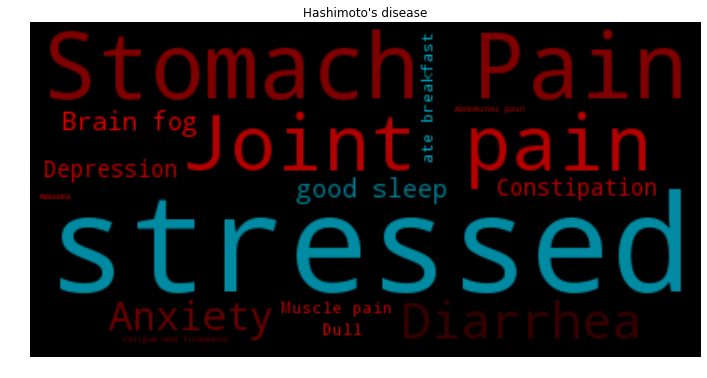

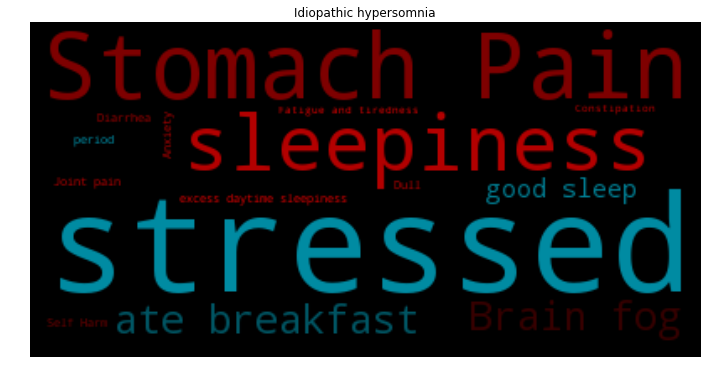

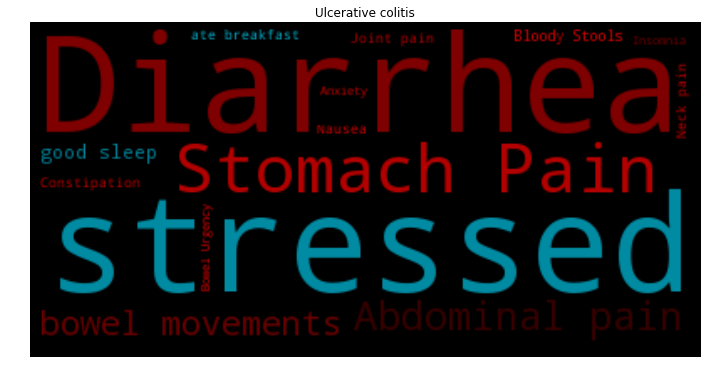

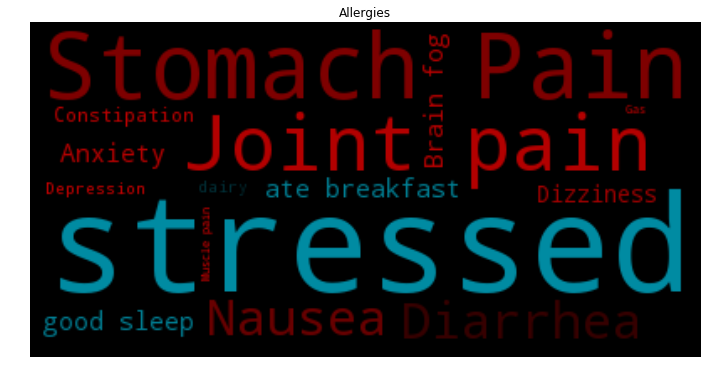

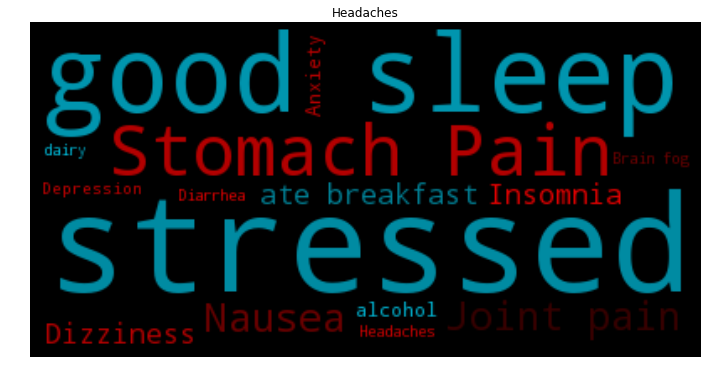

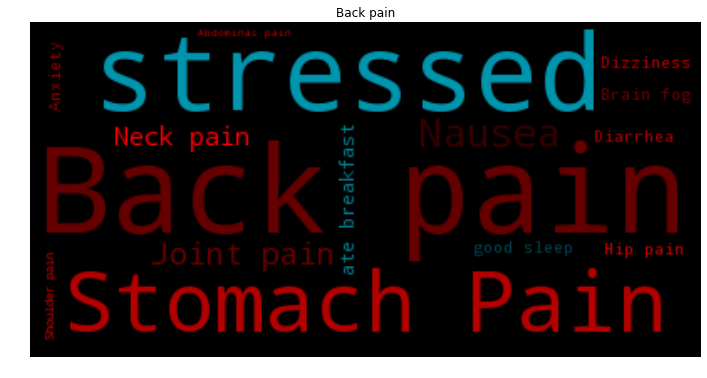

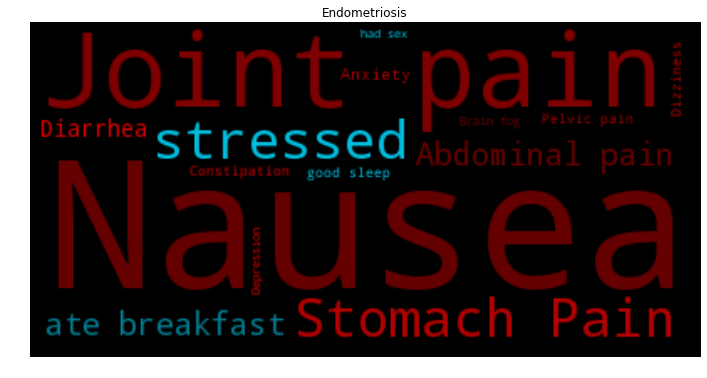

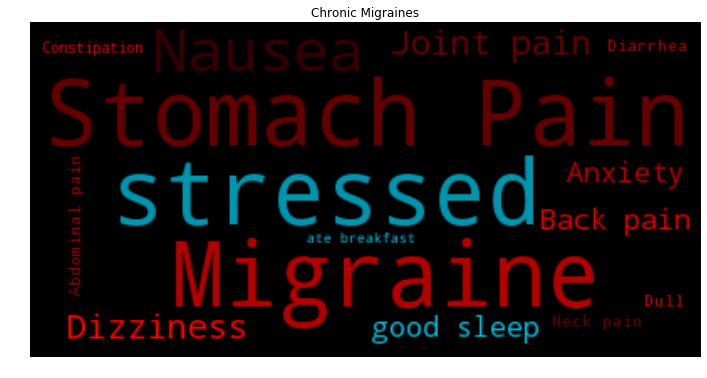

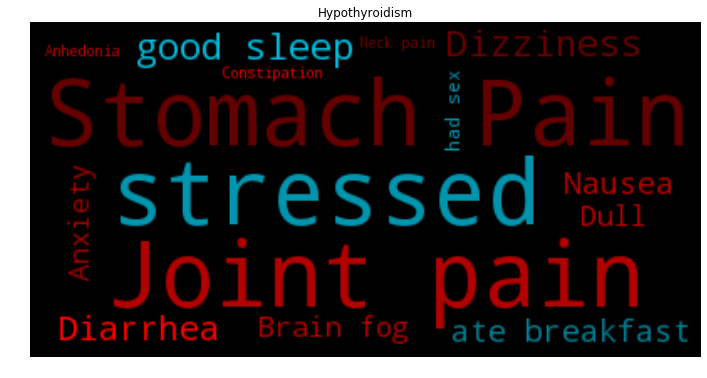

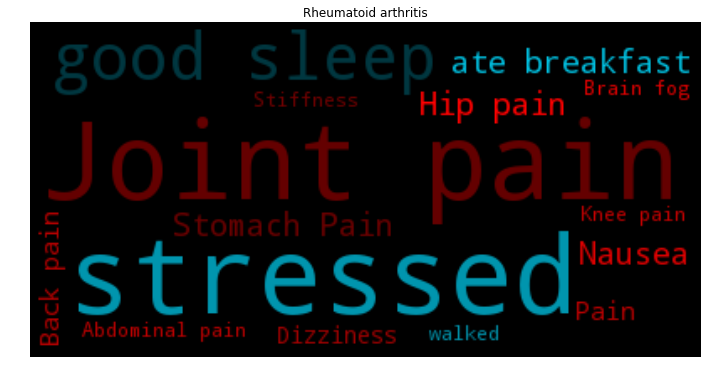

In [80]:
from PIL import ImageColor
import colorsys

def get_double_color_func(color1, color2):

    rgb_max = 255.
    
    old_r1, old_g1, old_b1 = ImageColor.getrgb(color1)
    h1, s1, v1 = colorsys.rgb_to_hsv(old_r1 / rgb_max, old_g1 / rgb_max, old_b1 / rgb_max)
    old_r2, old_g2, old_b2 = ImageColor.getrgb(color2)
    h2, s2, v2 = colorsys.rgb_to_hsv(old_r2 / rgb_max, old_g2 / rgb_max, old_b2 / rgb_max)

    def double_color_func(word=None, font_size=None, position=None,
                          orientation=None, font_path=None, random_state=None):
        if random_state is None:
            random_state = Random()
        r1, g1, b1 = colorsys.hsv_to_rgb(h1, s1, random_state.uniform(0.2, 1))
        r2, g2, b2 = colorsys.hsv_to_rgb(h2, s2, random_state.uniform(0.2, 1))
        if (word in symptoms['trackable_name'].values):
            return 'rgb({:.0f}, {:.0f}, {:.0f})'.format(r1 * rgb_max, g1 * rgb_max, b1 * rgb_max)
        else:
            return 'rgb({:.0f}, {:.0f}, {:.0f})'.format(r2 * rgb_max, g2 * rgb_max, b2 * rgb_max)
    return double_color_func

topConditions = df_conditions['trackable_name'].value_counts().index[0:20]
by_user = df.groupby('user_id')
for condition in topConditions:
    just_affected_users = df.groupby('user_id').filter(lambda x: condition in x['trackable_name'].values)
    symptoms = just_affected_users[just_affected_users['trackable_type'] == 'Symptom']
    tags = just_affected_users[just_affected_users['trackable_type'] == 'Tag']
    symptoms_and_tags = symptoms.append(tags)
    symptom_counts = defaultdict(int)
    #need to get the counts into this defaultdict nonsense
    for key,value in symptoms_and_tags['trackable_name'].value_counts().to_dict().iteritems():
        symptom_counts[key] = value
    #wc = WordCloud(max_words=1000, margin=10,random_state=1).generate(str(symptoms['trackable_name']))
    wc = WordCloud(max_words=15, margin=10,random_state=1)
    wc.generate_from_frequencies(symptom_counts.items())
    default_colors = wc.to_array()
    plt.figure(figsize=(12, 8))
    plt.title(condition)
    plt.axis("off")
    color_func2 = get_double_color_func('#FF0000','#00b4d2')  #specify an rgb color here
    #plt.imshow(wc.recolor(color_func=color_func2, random_state=3))
    plt.imshow(wc.recolor(color_func=color_func2, random_state=3))
    #plt.imshow(wc)